In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, 
    Dense, Dropout, 
    BatchNormalization, 
    Flatten
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os


In [33]:
def find_dataset_path():
    """
    Find the correct path to the Sign Language MNIST dataset
    
    Returns:
        tuple: Paths to training and testing CSV files
    """
    possible_paths = [
        # Current directory
        "sign_mnist_train.csv",
        "sign_mnist_test.csv",
        
        # Subdirectories
        "./data/sign_mnist_train.csv",
        "./data/sign_mnist_test.csv",
        
        # Full paths (modify as needed)
        "/content/sign_mnist_train.csv",  # Google Colab
        "/content/sign_mnist_test.csv",   # Google Colab
        
        # Add more potential paths here
    ]
    
    train_path = None
    test_path = None
    
    for path in possible_paths:
        if os.path.exists(path):
            if 'train' in path:
                train_path = path
            elif 'test' in path:
                test_path = path
    
    if not train_path or not test_path:
        raise FileNotFoundError("""
        Dataset files not found. 
        Please download Sign Language MNIST dataset from:
        - Kaggle
        - GitHub
        - Provide the correct file paths
        """)
    
    return train_path, test_path


In [34]:
# Load Sign Language data
def load_sign_language_data():
    """
    Load and preprocess Sign Language MNIST dataset
    
    Returns:
        tuple: Processed training and testing datasets
    """
    # Find dataset paths
    train_path, test_path = find_dataset_path()
    
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    
    # Separate features and labels
    X_train = train_df.iloc[:, 1:].values
    y_train = train_df.iloc[:, 0].values
    
    X_test = test_df.iloc[:, 1:].values
    y_test = test_df.iloc[:, 0].values
    
    # Normalize pixel values
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    # Reshape for CNN input
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    # One-hot encode labels
    y_train = to_categorical(y_train, num_classes=26)
    y_test = to_categorical(y_test, num_classes=26)
    
    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [38]:

# Build Sign Language Recognition Model
def build_sign_language_model(input_shape=(28, 28, 1), num_classes=26):
    model = Sequential([
        # Convolutional layers
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Flatten and Reshape for LSTM
        Flatten(),
        Reshape((-1, 64)),  # Reshape for LSTM input
        
        # LSTM Layers
        LSTM(128, return_sequences=True),
        LSTM(64, return_sequences=False),
        
        # Fully Connected Layers
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output Layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train and Evaluate Model
def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train and evaluate the sign language recognition model
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
    
    Returns:
        tuple: Trained model and training history
    """
    # Create model
    model = build_sign_language_model()
    
    # Training callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=10, 
        restore_best_weights=True
    )
    
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping, lr_reducer],
        verbose=1
    )
    
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
      
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix of Sign Language Recognition')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return model, history


In [39]:

# Visualize Training History
def plot_training_history(history):
    """
    Visualize training and validation metrics
    
    Args:
        history: Model training history
    """
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1/50


C:\Users\Computec\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


344/344 ━━━━━━━━━━━━━━━━━━━━ 48s 116ms/step - accuracy: 0.2192 - loss: 2.6453 - val_accuracy: 0.0373 - val_loss: 4.6839 - learning_rate: 0.0010
Epoch 2/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step - accuracy: 0.7224 - loss: 0.7707 - val_accuracy: 0.7902 - val_loss: 0.7036 - learning_rate: 0.0010
Epoch 3/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 109ms/step - accuracy: 0.9046 - loss: 0.2840 - val_accuracy: 0.9730 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 4/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.9569 - loss: 0.1285 - val_accuracy: 0.9718 - val_loss: 0.0968 - learning_rate: 0.0010
Epoch 5/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 38s 112ms/step - accuracy: 0.9750 - loss: 0.0780 - val_accuracy: 0.9761 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 6/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.9806 - loss: 0.0602 - val_accuracy: 0.9949 - val_loss: 0.0175 - learning_rate: 0.0010
Epoch 7/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 45s 130ms/step - accuracy: 0.9871 - loss:

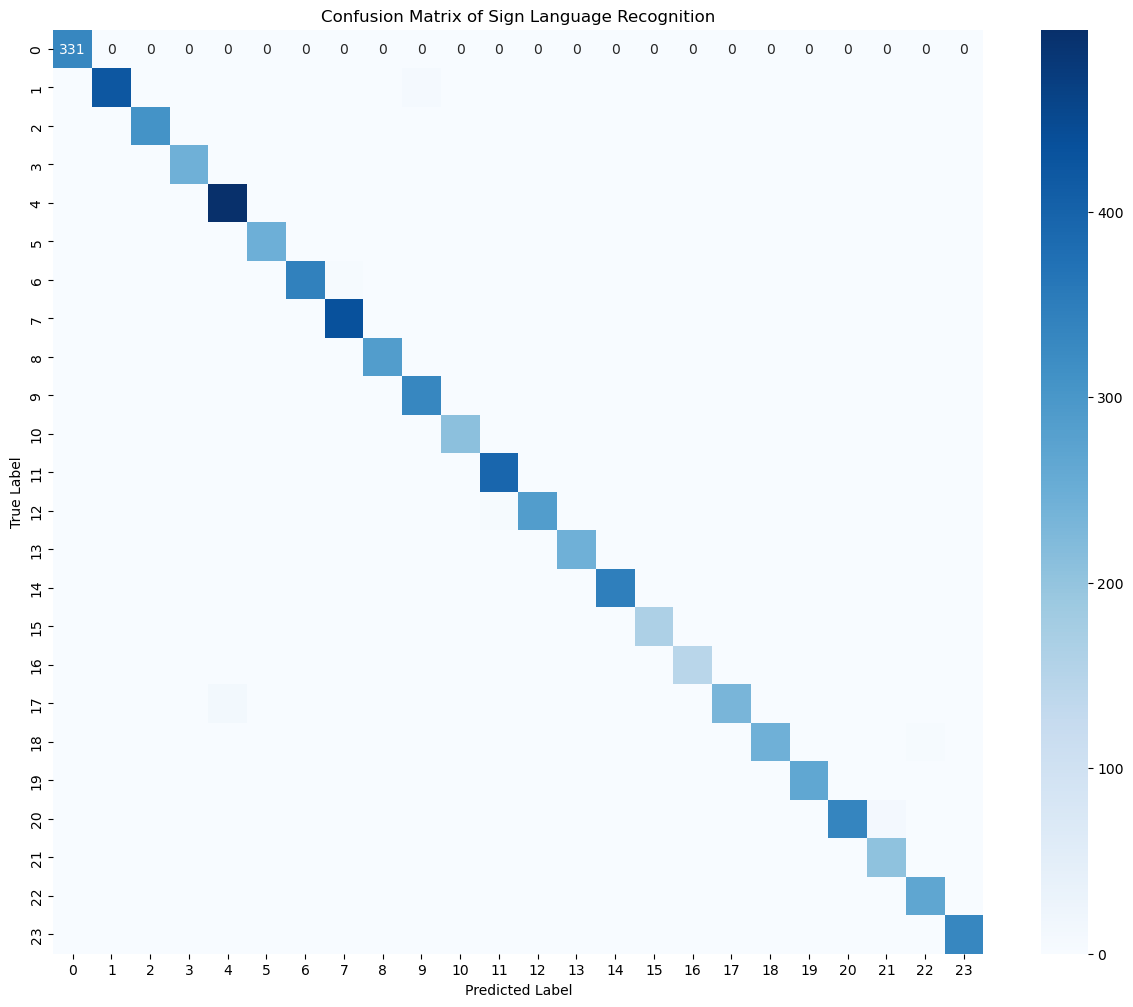

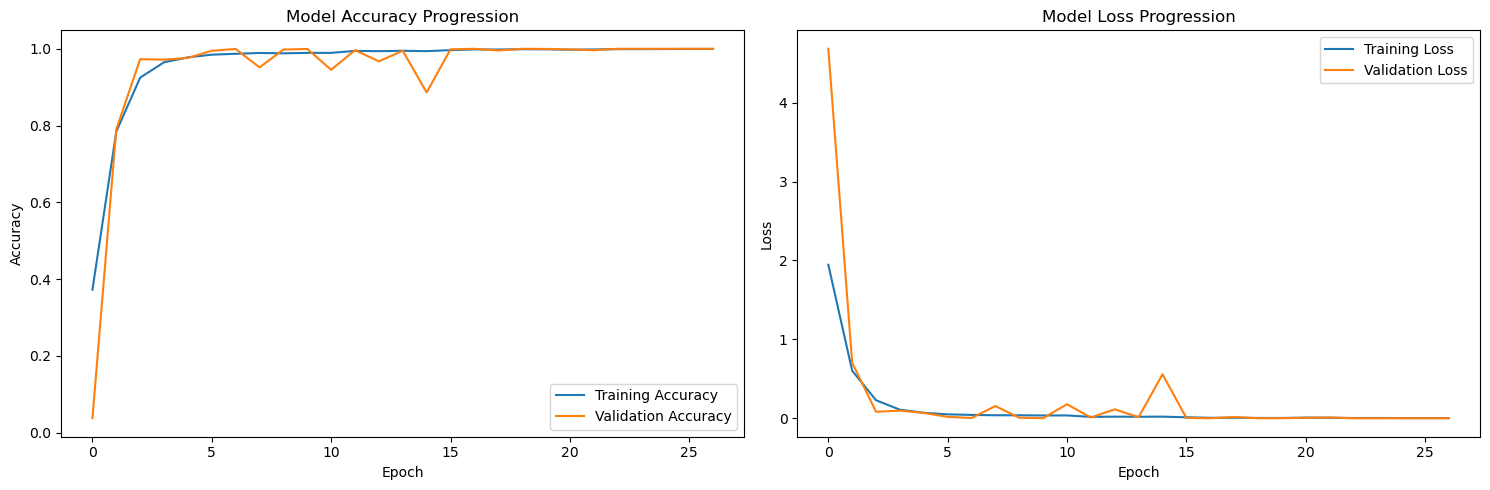

In [40]:
# Main Execution
def main():
    try:
        # Load data
        X_train, X_val, X_test, y_train, y_val, y_test = load_sign_language_data()
        
        # Train and evaluate model
        model, history = train_and_evaluate_model(
            X_train, y_train, X_val, y_val, X_test, y_test
        )
        
        # Plot training history
        plot_training_history(history)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        print("\nTroubleshooting Tips:")
        print("1. Ensure Sign Language MNIST dataset is downloaded")
        print("2. Check file paths")
        print("3. Verify dataset format")

# Run the main function
if __name__ == "__main__":
    main()